**First clone the github repository**

In [4]:
#%cd /content
#! git clone https://github.com/Tikquuss/lwd
#%cd lwd/scripts

# **Set-up** 
*Once this section is configured, you can comment (optionally) the previous cell and run everything at once (Runtime -> Run all).*  
**Once everything is executed, a csv file will be automatically created containing all the losses on the test data for each model.**

* Uncomment the line corresponding to your function, and choose the values of the bounds of the intervals in which the learning and test data will be generated (uniformly) : we have at the end of each line the corresponding values taken from the ["Sobolev Training"](https://arxiv.org/abs/1706.04859) original paper (page 14-15)
* The steps are used for the curves: they can therefore be chosen according to the desired precision.

In [5]:
f_name = "Styblinski-Tang" # https://www.sfu.ca/~ssurjano/stybtang.html (-5, 5), (-5, 5)
#f_name = "Ackley" # http://www.sfu.ca/~ssurjano/ackley.html (-5, 5), (-5, 5)
#f_name = "Beale" # https://www.sfu.ca/~ssurjano/beale.html (-4.5, 4.5), (-4.5, 4.5)
#f_name = "Booth" # https://www.sfu.ca/~ssurjano/booth.html (-10, 10), (-10, 10)
#f_name = "Bukin" # https://www.sfu.ca/~ssurjano/bukin6.html (-15, -5), (-3, 3)
#f_name = "McCormick" # https://www.sfu.ca/~ssurjano/mccorm.html (-1.5, 4), (-3, 4)
#f_name = "Rosenbrock" # https://www.sfu.ca/~ssurjano/rosen.html (-2, 2), (-2, 2)

(min_x, max_x), (min_y, max_y) = (-5, 5), (-5, 5) 
step_x, step_y = 0.25, 0.25

In [6]:
try:
    %tensorflow_version 1.x
    %matplotlib inline
except Exception:
    pass

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import os

from utils import gradient, genData, plotFunction, plotGrad, get_data_loader, plot_stat, global_stat, to_csv
from utils import forward, backprop, MLP, Siren, train, test
from twin_net_tf import graph, Generator, test as twin_net_tf_test 
from twin_net_tf_siren import test as twin_net_tf_test_siren
from functions import * # Styblinski-Tang (ST), Ackley, Beale, Booth, Bukin, McCormick, Rosenbrock

1.15.2
False


1.15.2
False


In [7]:
# Global
max_epoch = 1  # maximun number of epoch
batch_size = 64 # batch_size
nTrain = 5 # number of training examples
nTest = 5 # number of testexamples

learning_rate = 3e-5 # learning rate

learning_rate_schedule = [(0.0, 1.0e-8), (0.2, 0.1), (0.6, 0.01), (0.9, 1.0e-6), (1.0, 1.0e-8)]

improving_limit = float("inf") # Stop training if the training loss does not decrease n times (no limit here)
INPUT_DIM = 2 
HIDDEN_DIM = 20
N_HIDDEN = 4 # number of hidden layers
OUTPUT_DIM = 1

# hyperparameters in the different loss functions to express a tradeoff between y loss and dydx loss
loss_config = {'alpha': 1, "beta" : 1} # loss = alpha * loss_y + beta * loss_dydx

# twin_net
train_seed, test_seed = 0, 0

# MLP
activation_function = F.softplus
deriv_activation_function = torch.sigmoid # for twin_net_pytorch
mlp_model_kwargs = {"in_features" : INPUT_DIM, # depends on the function
                    "hidden_features" : HIDDEN_DIM, 
                    "hidden_layers" : N_HIDDEN, 
                    "out_features": OUTPUT_DIM, 
                    "activation_function" : activation_function, 
                    "deriv_activation_function" : deriv_activation_function,
                   }
# Siren
first_omega_0 = 30.
hidden_omega_0 = 30.
outermost_linear = True

siren_model_kwargs = {"in_features" : INPUT_DIM, 
                      "hidden_features" : HIDDEN_DIM, 
                      "hidden_layers" : N_HIDDEN, 
                      "out_features": OUTPUT_DIM, 
                      "outermost_linear" : outermost_linear, 
                      "first_omega_0" : first_omega_0, 
                      "hidden_omega_0" : hidden_omega_0}

# twin_net tf                
generator_kwargs = {"hidden_units" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN}


main_path = "/content"

# **To avoid repeating the same code too much**

In [8]:
def run_train(name, model_class, model_kwargs, with_derivative, name_function, name_grad,  
              normalize = False, learning_rate_schedule = None):
    global x_train, y_train, dydx_train, x_test, y_test, dydx_test 
    global batch_size, learning_rate, max_epoch, improving_limit
    global min_x, max_x, step_x, min_y, max_y, step_y
    global loss_config

    if with_derivative :
        train_dataloader, config = get_data_loader(x = x_train, y = y_train,  dydx = dydx_train, 
                                                   batch_size = batch_size, normalize = normalize)
        test_dataloader, _ = get_data_loader(x = x_test, y = y_test,  dydx = dydx_test, batch_size = batch_size)
    else :
        train_dataloader, config = get_data_loader(x = x_train, y = y_train,  dydx = None, 
                                                   batch_size = batch_size, normalize = normalize)
        test_dataloader, _ = get_data_loader(x = x_test, y = y_test, dydx = None, batch_size = batch_size)

    config["learning_rate_schedule"] = learning_rate_schedule
    config.update(loss_config)
     
    model = model_class(**model_kwargs)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    
    model, stats, best_loss = train(name, model, train_dataloader, optimizer, criterion, config, 
                                    with_derivative, max_epoch = max_epoch, improving_limit = improving_limit)
    
    plot_stat(stats, with_derivative = with_derivative)

    (test_loss, r_y, r_dydx), (x_list, y_list, dydx_list, y_pred_list, dydx_pred_list) = test(
        name, model, test_dataloader, criterion, config, with_derivative
    )

    x_mean, x_std = config.get("x_mean", 0.), config.get("x_std", 1.)
    y_mean, y_std = config.get("y_mean", 0.), config.get("y_std", 1.)
    dydx_mean, dydx_std = config.get("dydx_mean", 0.), config.get("dydx_std", 1.)

    def function(x):
        x = torch.tensor(x)
        x_scaled = (x-x_mean) / x_std
        y_pred_scaled = model(x = x_scaled.float())
        y_pred = y_mean + y_std * y_pred_scaled
        y_pred = y_pred.detach().squeeze().numpy()
        return y_pred

    def deriv_function(index):
        def f(x) :
            x = torch.tensor(x, requires_grad = True)
            x_scaled = (x-x_mean) / x_std
            if name == "net" :
                y_pred_scaled = model(x = x_scaled.float()) 
                dydx_pred_scaled = gradient(y_pred_scaled, x_scaled)
            elif name == "twin_net" :
                y_pred_scaled, zs = forward(net = model.net, x = x_scaled.float(), return_layers = True)
                dydx_pred_scaled = backprop(net = model.net, y = y_pred_scaled, zs = zs)
            dydx_pred = dydx_mean + dydx_std * dydx_pred_scaled
            dydx_pred = dydx_pred.detach().squeeze().numpy()
            return dydx_pred[index]
        return f

    plotFunction(name = name_function, function = function, 
                 min_x = min_x, max_x = max_x, step_x = step_x, 
                 min_y = min_y, max_y = max_y, step_y = step_y)

    plotGrad(name = name_grad, deriv_function = deriv_function, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)
    
    return model, test_loss, stats

def run_diffML_train(name, generator, generator_kwargs, name_function, name_grad, siren = False, normalize = True):
    global nTrain, nTest, train_seed, test_seed
    global min_x, max_x, step_x, min_y, max_y, step_y
    global max_epoch, improving_limit
    global first_omega_0, hidden_omega_0, outermost_linear
    if siren :
        dic_loss, regressor, dtrain, dtest, dydxTest, values, deltas = twin_net_tf_test_siren(
              generator, [nTrain], 
              nTrain, nTest, 
              trainSeed = train_seed, testSeed = test_seed, weightSeed = 0, 
              deltidx=0,
              generator_kwargs = generator_kwargs,
              epochs = max_epoch,
              first_omega_0 = first_omega_0, 
              hidden_omega_0 = hidden_omega_0, 
              outermost_linear = outermost_linear,
              normalize = normalize,
              improving_limit = improving_limit
          )
    else :
        dic_loss, regressor, dtrain, dtest, dydxTest, values, deltas = twin_net_tf_test(
              generator, [nTrain], 
              nTrain, nTest, 
              trainSeed = train_seed, testSeed = test_seed, weightSeed = 0, 
              deltidx=0,
              generator_kwargs = generator_kwargs,
              epochs = max_epoch,
              normalize = normalize,
              improving_limit = improving_limit
          )
    
    plot_stat(regressor.stats["normal"], with_derivative = with_derivative)
    plot_stat(regressor.stats["differential"], with_derivative = with_derivative)

    plotFunction(name = name_function, function =  lambda x : regressor.predict_values([x])[0][0], 
                 min_x = min_x, max_x = max_x, step_x = step_x, 
                 min_y = min_y, max_y = max_y, step_y = step_y)

    plotGrad(name = name_grad, 
            deriv_function = lambda index : lambda x : regressor.predict_values_and_derivs([x])[1][0][index], 
            min_x = min_x, max_x = max_x, step_x = step_x, 
            min_y = min_y, max_y = max_y, step_y = step_y)

    # show_graph_per_axis
    yTest = dtest[1]
    for i in range(2) :
        xAxis  = np.array([[x[i]] for x in dtest[0]])
        # show predicitions
        graph("%s x%d vs y" % (name, (i+1)), values, xAxis, "", "values", yTest, [nTrain], True)
        # show deltas
        graph("%s x%d vs dxdy" % (name, (i+1)), deltas, xAxis, "", "deltas", dydxTest, [nTrain], True)

    loss = {"normal" : dic_loss['standard_loss']["yloss"][-1], 
            "differential" : dic_loss['differential_loss']["yloss"][-1]}

    return regressor, loss

In [9]:
if f_name == "Styblinski-Tang" :
    callable_function = STFunction
    callable_function_deriv = STDeriv
    function = "Styblinski-Tang Function"
elif f_name == "Ackley" :
    callable_function = AckleyFunction
    callable_function_deriv = AckleyDeriv
    function = "Ackley Function"
elif f_name == "Beale" :
    callable_function = BealeFunction
    callable_function_deriv = BealeDeriv
    function = "Beale Function"
elif f_name == "Booth" :
    callable_function = BoothFunction
    callable_function_deriv = BoothDeriv
    function = "Booth Function"
elif f_name == "Bukin" :
    callable_function = BukinFunction
    callable_function_deriv = BukinDeriv
    function = "Bukin Function"
elif f_name == "McCormick" :
    callable_function = McCormickFunction
    callable_function_deriv = McCormickDeriv
    function = "McCormick Function"
elif f_name == "Rosenbrock" :
    callable_function = RosenbrockFunction
    callable_function_deriv = RosenbrockDeriv
    function = "Rosenbrock Function"

csv_path = os.path.join(main_path, f_name + ".csv")
grad = "Gradient Field of %s" % function

# **Ground Truth**

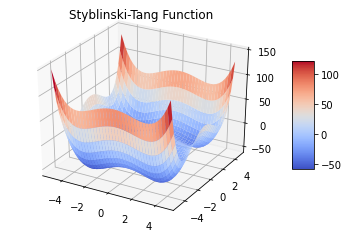

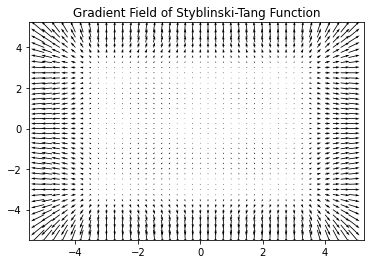

In [10]:
plotFunction(name = function, function = callable_function, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)

plotGrad(name = grad, deriv_function = callable_function_deriv, 
         min_x = min_x, max_x = max_x, step_x = step_x, 
         min_y = min_y, max_y = max_y, step_y = step_y)

# **Data**

In [11]:
batch_samples = genData(
                        function = STFunction, 
                        deriv_function = STDeriv, 
                        dim_x = INPUT_DIM,
                        min_x = min_x, max_x = max_x, num_samples = nTrain
                )

x_train = [bs[0] for bs in batch_samples]
y_train = [bs[1] for bs in batch_samples]
dydx_train = [bs[2] for bs in batch_samples]

batch_samples = genData(
                        function = STFunction, 
                        deriv_function = STDeriv, 
                        dim_x = INPUT_DIM,
                        min_x = min_x, max_x = max_x, num_samples = nTest
                )

x_test = [bs[0] for bs in batch_samples]
y_test = [bs[1] for bs in batch_samples]
dydx_test = [bs[2] for bs in batch_samples]

stats_dic = {}
tests_loss = {}

# **1) Normal Training**

In [12]:
name = "net"
with_derivative = False
key1 = "normal_training"
name_function = '%s %s' % (function, key1)
name_grad = '%s %s' % (grad, key1)
stats_dic[key1] = {}
tests_loss[key1] = {}

## **1.1) with MLP**

In [13]:
model_class = MLP
key2 = "mlp"
stats_dic[key1][key2] = {}
tests_loss[key1][key2] = {}

### **1.1.1) normalize = False**

In [14]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 150.56651306152344 train loss no scaled: 150.56651306152344





test loss: 2599.91162109375 test loss no scaled 2599.91162109375


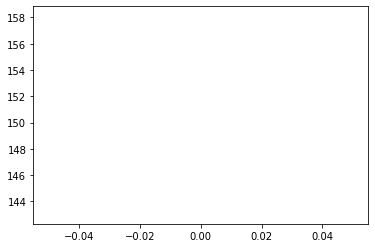

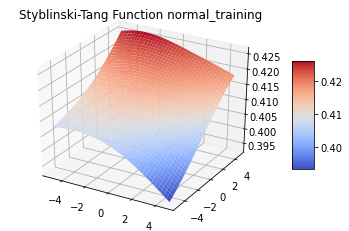

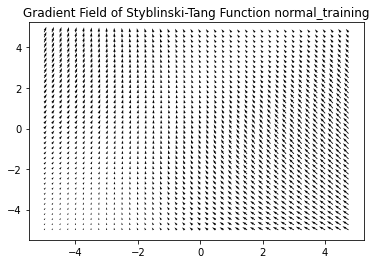

In [15]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 141.51980590820312 train loss no scaled: 141.51980590820312





test loss: 2599.073974609375 test loss no scaled 2599.073974609375


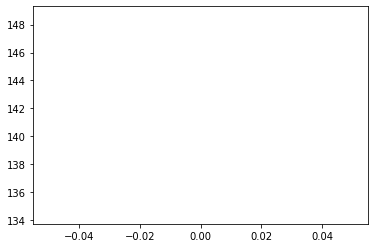

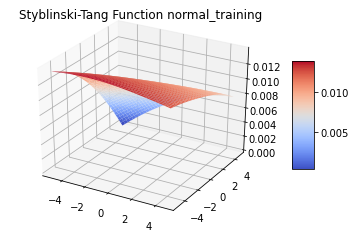

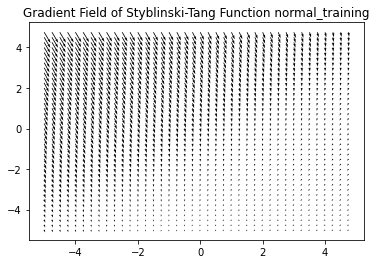

In [16]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = learning_rate_schedule
        )

### **1.1.2) normalize = True**

In [17]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 1.029423475265503 train loss no scaled: 23.182519912719727





test loss: 119.87684631347656 test loss no scaled 2699.615966796875


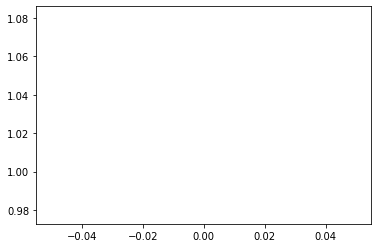

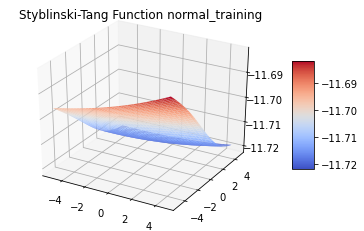

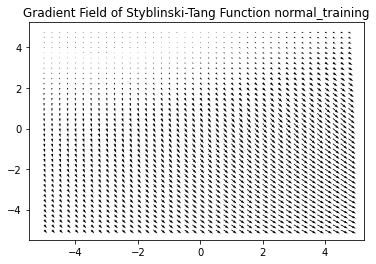

In [18]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 1.124801516532898 train loss no scaled: 25.330419540405273





test loss: 117.8599624633789 test loss no scaled 2654.19580078125


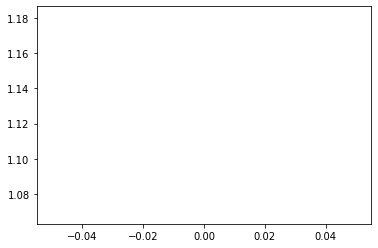

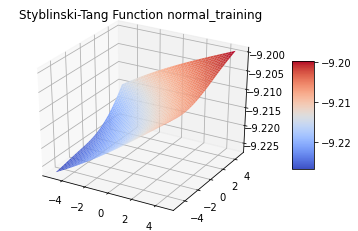

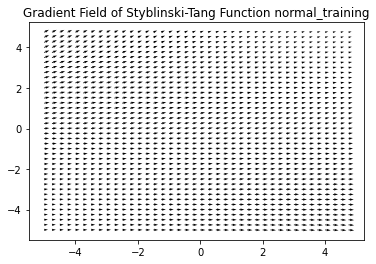

In [19]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = learning_rate_schedule
        )

## **1.2) with Siren**

In [20]:
model_class = Siren
key2 = "siren"
stats_dic[key1][key2] = {}
tests_loss[key1][key2] = {}

### **1.2.1) normalize = False**

In [21]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 145.18960571289062 train loss no scaled: 145.18960571289062





test loss: 2599.39794921875 test loss no scaled 2599.39794921875


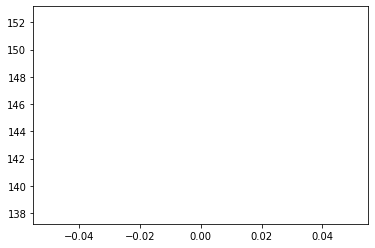

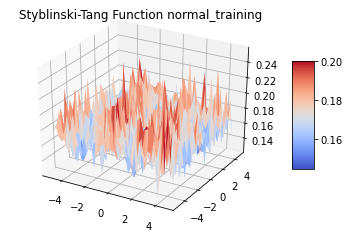

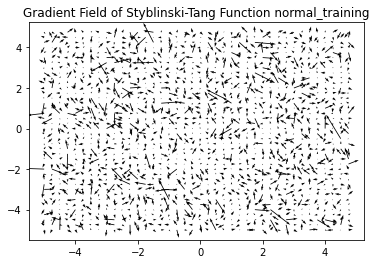

In [22]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 145.30276489257812 train loss no scaled: 145.30276489257812





test loss: 2597.4765625 test loss no scaled 2597.4765625


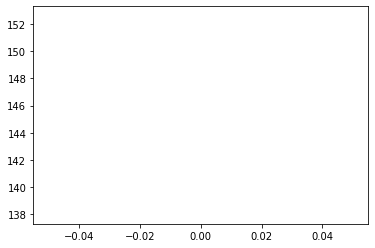

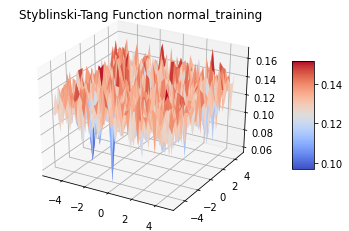

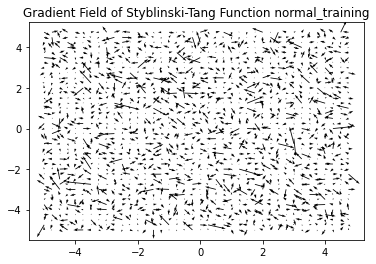

In [23]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = learning_rate_schedule
        )

### **1.2.2) normalize = True**

In [24]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 1.0495028495788574 train loss no scaled: 23.634702682495117





test loss: 119.2020034790039 test loss no scaled 2684.41845703125


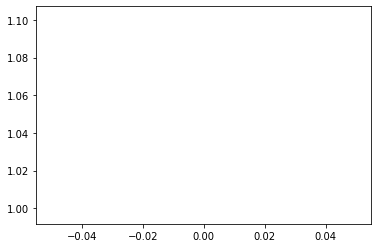

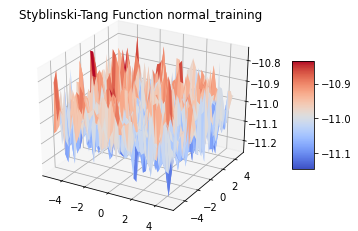

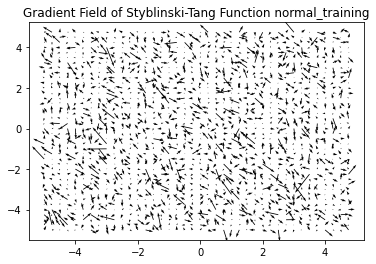

In [25]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 1.0093306303024292 train loss no scaled: 22.730030059814453





test loss: 118.42256164550781 test loss no scaled 2666.86474609375


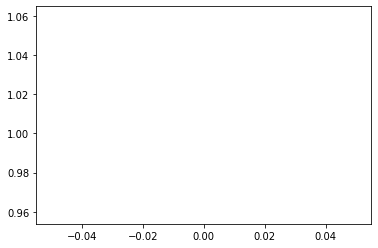

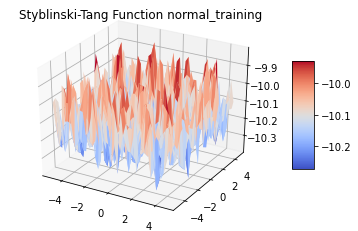

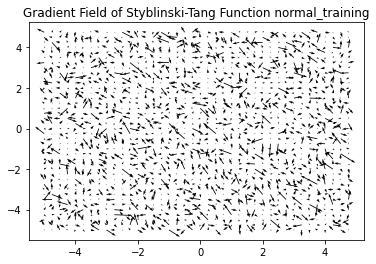

In [26]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = learning_rate_schedule
        )

# **2) Sobolev Training**

In [27]:
name = "net"
with_derivative = True
key1 = "sobolev_training"
name_function = '%s %s' % (function, key1)
name_grad = '%s %s' % (grad, key1)
stats_dic[key1] = {}
tests_loss[key1] = {}

## **2.1) with MLP**

In [28]:
model_class = MLP
key2 = "mlp"
stats_dic[key1][key2] = {}
tests_loss[key1][key2] = {}

### **2.1.1) normalize = False**

In [29]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 1387.91015625, y loss : 132.71376037597656, dy loss : 1255.1964111328125

train loss no scaled: 1387.910171508789, y loss  no scaled : 132.71376037597656, dy loss  no scaled: 1255.1964111328125






test loss: 5996.7939453125, y loss : 2597.83740234375, dydx loss : 3398.95654296875

test loss no scaled: 5996.7939453125, y loss  no scaled : 2597.83740234375, dydx loss  no scaled: 3398.95654296875




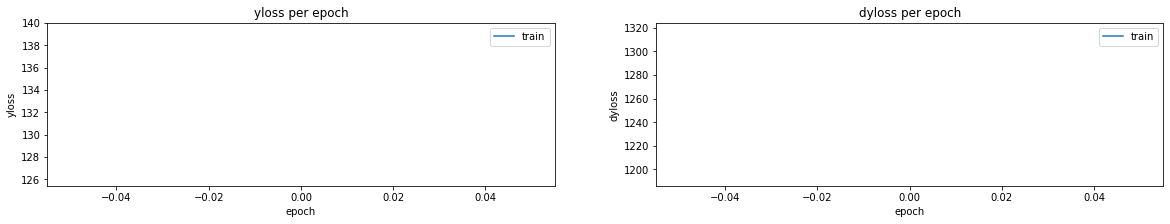

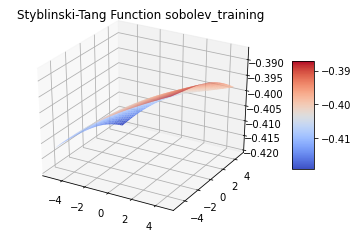

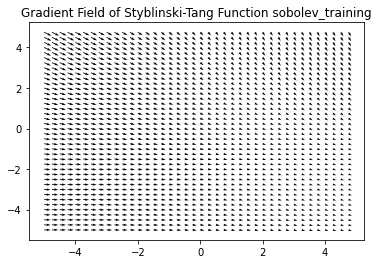

In [30]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 1381.3778076171875, y loss : 126.16828918457031, dy loss : 1255.20947265625

train loss no scaled: 1381.3777618408203, y loss  no scaled : 126.16828918457031, dy loss  no scaled: 1255.20947265625






test loss: 5995.8037109375, y loss : 2596.963134765625, dydx loss : 3398.840576171875

test loss no scaled: 5995.8037109375, y loss  no scaled : 2596.963134765625, dydx loss  no scaled: 3398.840576171875




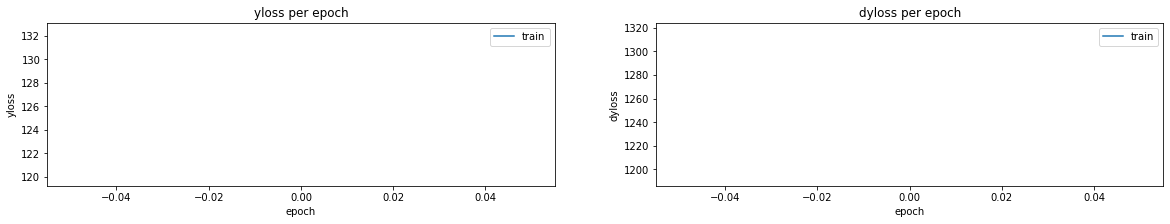

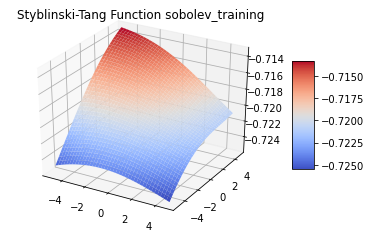

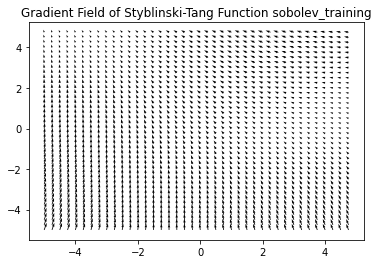

In [31]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = learning_rate_schedule
        )

### **2.1.2) normalize = True**

In [32]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 2.8801324367523193, y loss : 1.8809150457382202, dy loss : 0.9992173910140991

train loss no scaled: 1254.465815068003, y loss  no scaled : 42.358028411865234, dy loss  no scaled: 1212.1077866561377






test loss: 155.61033886010088, y loss : 116.40373229980469, dydx loss : 39.206606560296194

test loss no scaled: 6339.7100597094095, y loss  no scaled : 2621.40185546875, dydx loss  no scaled: 3718.3082042406595




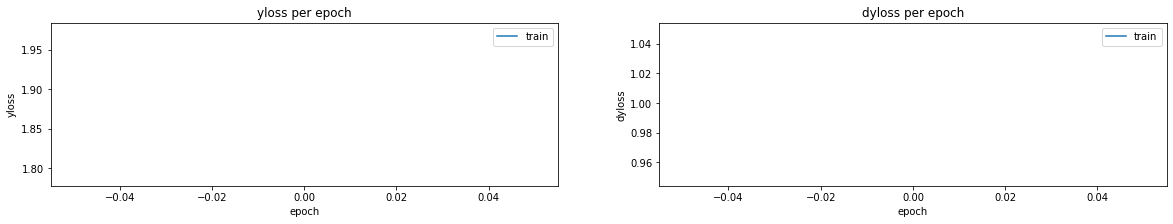

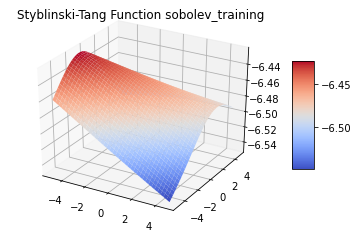

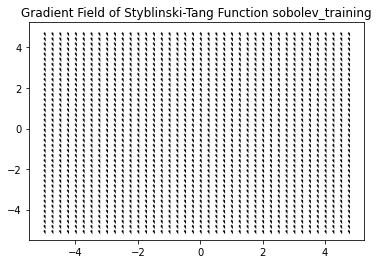

In [33]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(
          name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 2.0438578128814697, y loss : 1.0442519187927246, dy loss : 0.9996058344841003

train loss no scaled: 1234.3672204494621, y loss  no scaled : 23.516450881958008, dy loss  no scaled: 1210.8507695675041






test loss: 157.44954012068735, y loss : 118.26316833496094, dydx loss : 39.18637178572642

test loss no scaled: 6378.249748541296, y loss  no scaled : 2663.27587890625, dydx loss  no scaled: 3714.973869635046




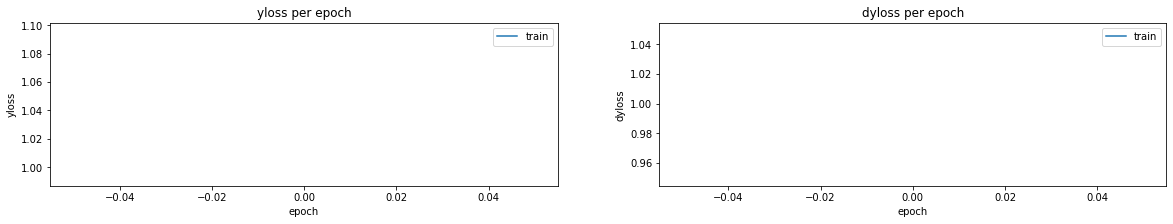

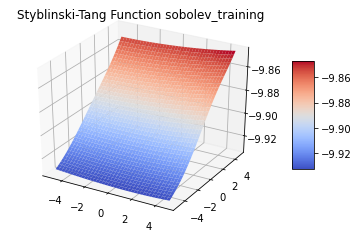

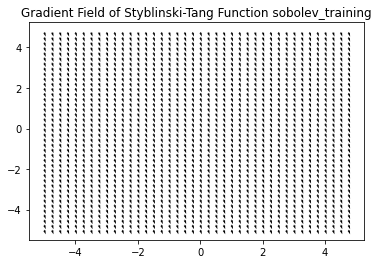

In [34]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(
          name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = learning_rate_schedule
        )

## **2.2) with Siren**

In [35]:
model_class = Siren
key2 = "siren"
stats_dic[key1][key2] = {}
tests_loss[key1][key2] = {}

### **2.2.1) normalize = False**

In [36]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 1368.20458984375, y loss : 139.17556762695312, dy loss : 1229.029052734375

train loss no scaled: 1368.2046203613281, y loss  no scaled : 139.17556762695312, dy loss  no scaled: 1229.029052734375






test loss: 5997.6953125, y loss : 2597.763427734375, dydx loss : 3399.93212890625

test loss no scaled: 5997.695556640625, y loss  no scaled : 2597.763427734375, dydx loss  no scaled: 3399.93212890625




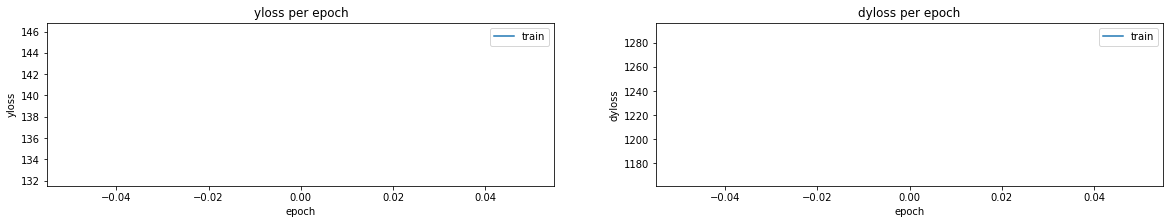

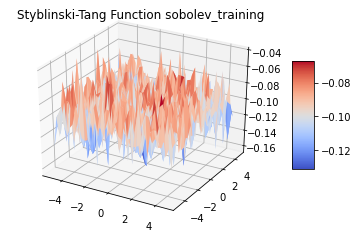

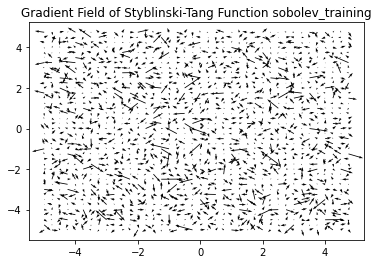

In [37]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 1391.4339599609375, y loss : 140.9410858154297, dy loss : 1250.492919921875

train loss no scaled: 1391.4340057373047, y loss  no scaled : 140.9410858154297, dy loss  no scaled: 1250.492919921875






test loss: 5999.56103515625, y loss : 2598.706787109375, dydx loss : 3400.854248046875

test loss no scaled: 5999.56103515625, y loss  no scaled : 2598.706787109375, dydx loss  no scaled: 3400.854248046875




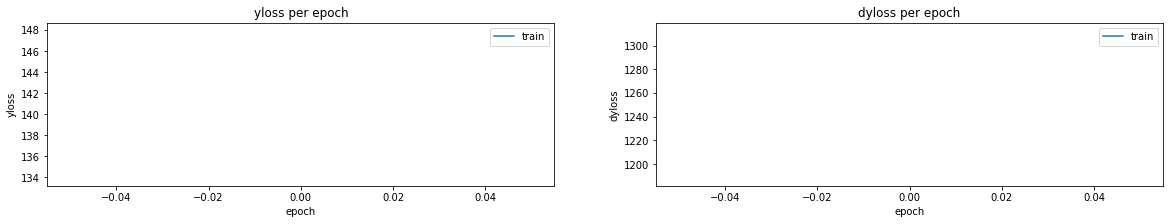

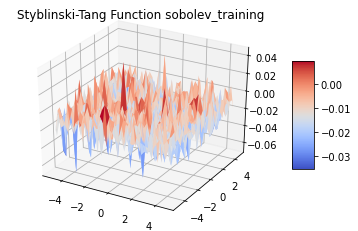

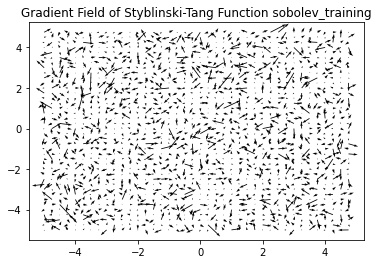

In [38]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = True, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = learning_rate_schedule
        )

### **2.2.2) normalize = True**

In [39]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 2.5724570751190186, y loss : 1.0415756702423096, dy loss : 1.530881404876709

train loss no scaled: 2008.9458462289554, y loss  no scaled : 23.45618438720703, dy loss  no scaled: 1985.4896618417483






test loss: 158.87670745951, y loss : 119.78167724609375, dydx loss : 39.09503021341624

test loss no scaled: 6372.472486525761, y loss  no scaled : 2697.47216796875, dydx loss  no scaled: 3675.0003185570117




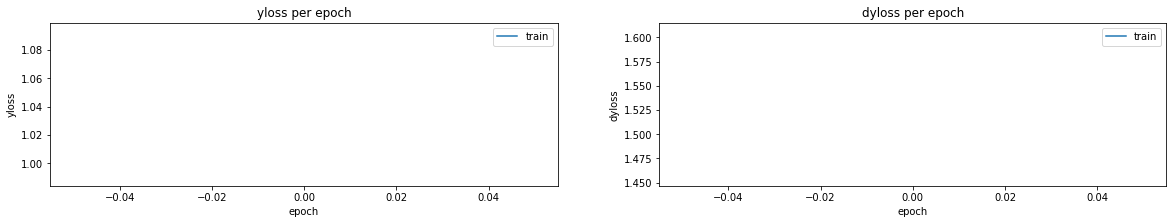

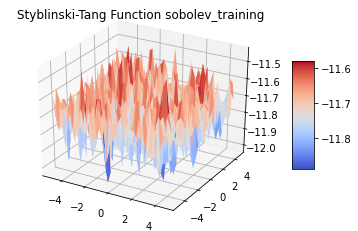

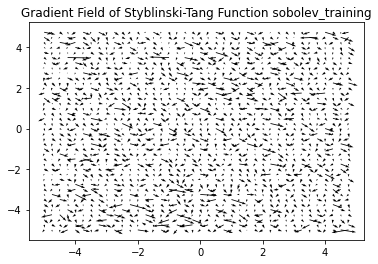

In [40]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 2.5552568435668945, y loss : 1.0097490549087524, dy loss : 1.5455076694488525

train loss no scaled: 1878.7567723122665, y loss  no scaled : 22.73945426940918, dy loss  no scaled: 1856.0173180428574






test loss: 156.76964465869216, y loss : 119.60640716552734, dydx loss : 37.16323749316482

test loss no scaled: 5873.508592369046, y loss  no scaled : 2693.525390625, dydx loss  no scaled: 3179.983201744046




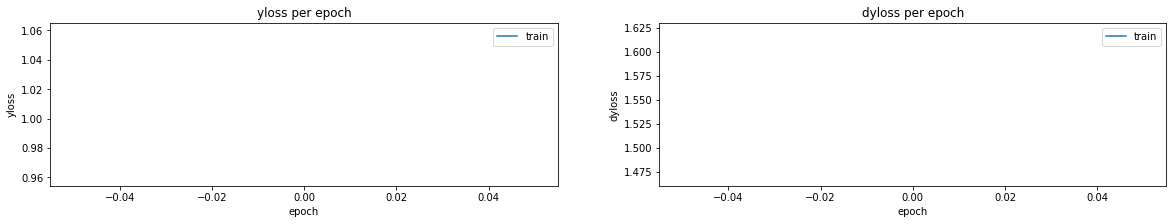

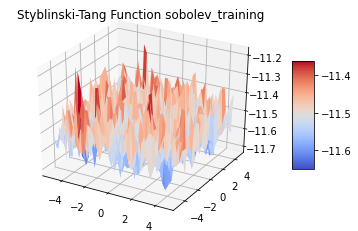

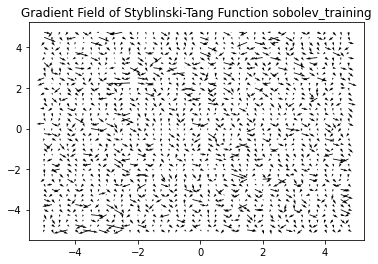

In [41]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = learning_rate_schedule
        )

# **3) twin_net tensorflow**

In [42]:
generator = Generator(callable_function = callable_function, 
                      callable_function_deriv = callable_function_deriv, 
                      dim_x = INPUT_DIM,
                      min_x = min_x, max_x = max_x)

key1 = "twin_net_tf"
name_function = '%s %s' % (function, key1)
name_grad = '%s %s' % (grad, key1)
key1_1 = "%s_normal" % key1
key1_2 = "%s_differential" % key1
stats_dic[key1_1] = {}
stats_dic[key1_2] = {}
tests_loss[key1_1] = {}
tests_loss[key1_2] = {}

## **3.1) with MLP**

In [43]:
key2 = "mlp"
stats_dic[key1_1][key2] = {}
stats_dic[key1_2][key2] = {}
tests_loss[key1_1][key2] = {}
tests_loss[key1_2][key2] = {}

### **3.1.1) normalize = False**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 5


Epoch 0: y loss scaled : 855.22412109375, dy loss _scaled : 198.12646484375

y loss no scaled : 855.22412109375, dy loss no scaled : 198.12646484375



test y loss : 855.22412109375, test dy loss : 198.12646484375


Epoch 0: y loss scaled : 855.22412109375, dy loss _scaled : 198.12646484375

y loss no scaled : 855.22412109375, dy loss no scaled : 198.12646484375



test y loss : 855.22412109375, test dy loss : 198.12646484375


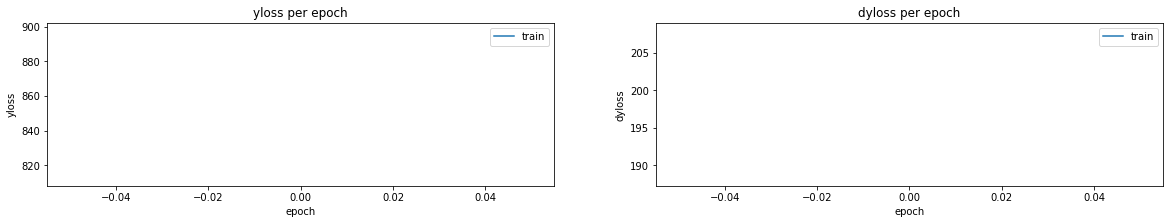

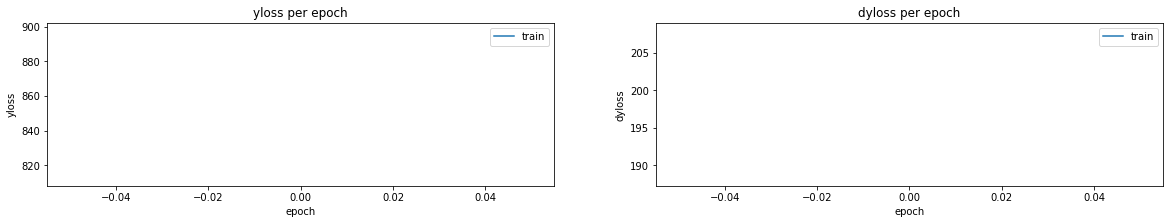

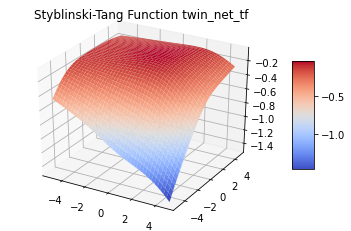

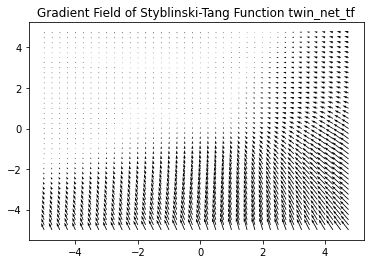

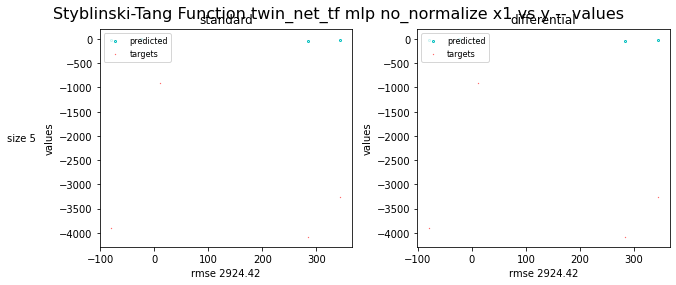

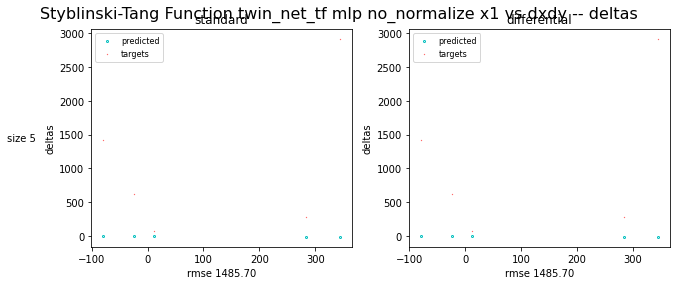

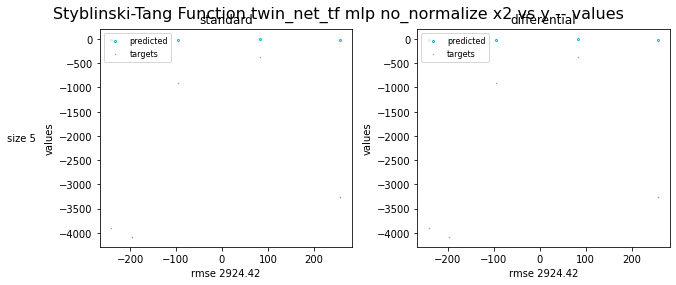

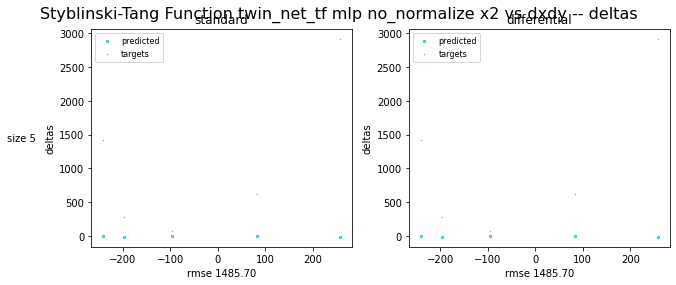

In [44]:
key3 = "no_normalize"
stats_dic[key1_1][key2][key3] = [None, None]
stats_dic[key1_2][key2][key3] = [None, None]
tests_loss[key1_1][key2][key3] = [None, None]
tests_loss[key1_2][key2][key3] = [None, None]

graph_name = "%s %s %s" % (name_function, key2, key3)
regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad, normalize = False)

stats_dic[key1_1][key2][key3][0] = stats_dic[key1_1][key2][key3][1] = regressor.stats["normal"]
stats_dic[key1_2][key2][key3][0] = stats_dic[key1_2][key2][key3][1] = regressor.stats["differential"]
tests_loss[key1_1][key2][key3][0] = tests_loss[key1_1][key2][key3][1] = loss["normal"]
tests_loss[key1_2][key2][key3][0] = tests_loss[key1_2][key2][key3][1] = loss["differential"]

### **3.1.2) normalize = True**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 5


Epoch 0: y loss scaled : 0.9615978002548218, dy loss _scaled : 2.55854868888855

y loss no scaled : 232.7640838623047, dy loss no scaled : 0.03370702266693115



test y loss : 232.7640838623047, test dy loss : 195.2478790283203


Epoch 0: y loss scaled : 0.9615978002548218, dy loss _scaled : 2.55854868888855

y loss no scaled : 232.76406860351562, dy loss no scaled : 0.03370702266693115



test y loss : 232.76406860351562, test dy loss : 195.2478790283203


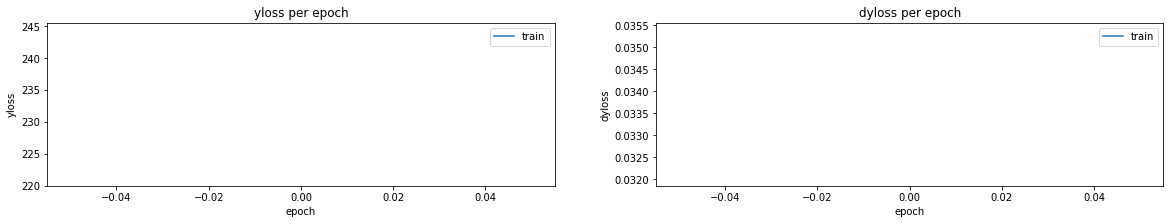

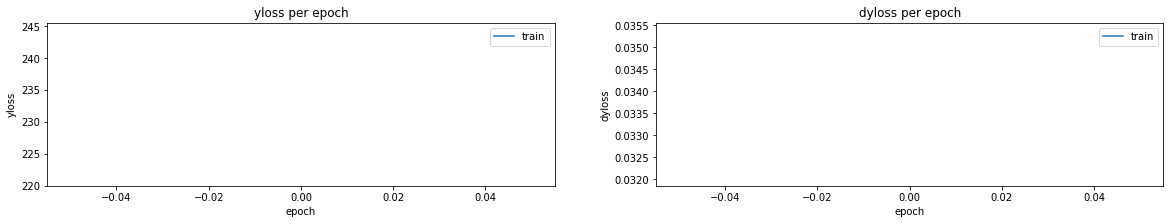

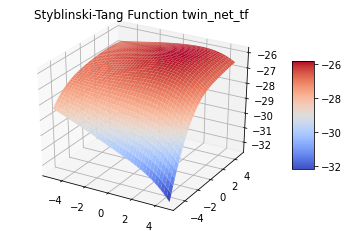

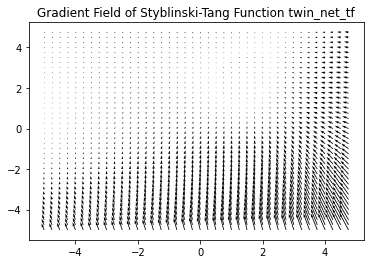

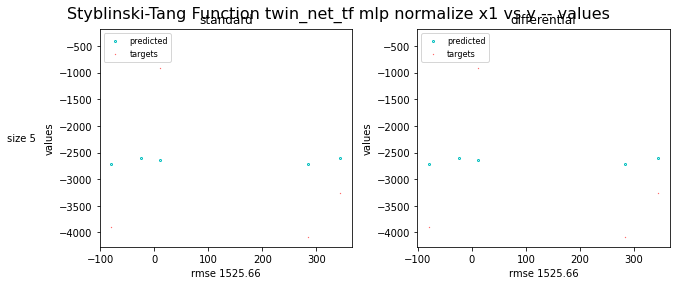

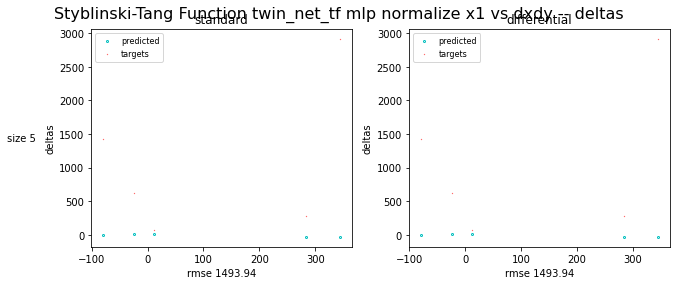

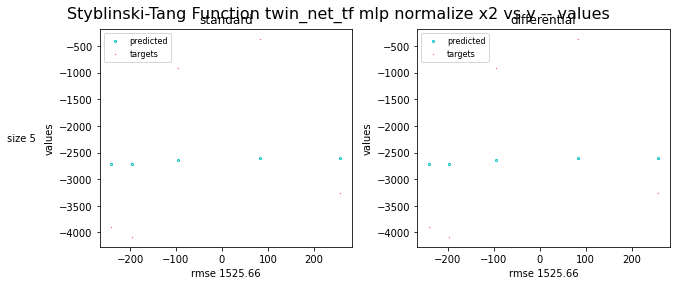

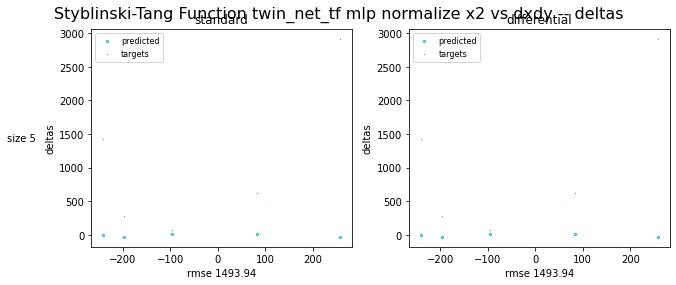

In [45]:
key3 = "normalize"
stats_dic[key1_1][key2][key3] = [None, None]
stats_dic[key1_2][key2][key3] = [None, None]
tests_loss[key1_1][key2][key3] = [None, None]
tests_loss[key1_2][key2][key3] = [None, None]

graph_name = "%s %s %s" % (name_function, key2, key3)
regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad, normalize = True)

stats_dic[key1_1][key2][key3][0] = stats_dic[key1_1][key2][key3][1] = regressor.stats["normal"]
stats_dic[key1_2][key2][key3][0] = stats_dic[key1_2][key2][key3][1] = regressor.stats["differential"]
tests_loss[key1_1][key2][key3][0] = tests_loss[key1_1][key2][key3][1] = loss["normal"]
tests_loss[key1_2][key2][key3][0] = tests_loss[key1_2][key2][key3][1] = loss["differential"]

## **3.2) with Siren**

In [46]:
key2 = "siren"
stats_dic[key1_1][key2] = {}
stats_dic[key1_2][key2] = {}
tests_loss[key1_1][key2] = {}
tests_loss[key1_2][key2] = {}

### **3.2.1) normalize = False**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 5


Epoch 0: y loss scaled : 777.4991455078125, dy loss _scaled : 192.0936737060547

y loss no scaled : 777.4991455078125, dy loss no scaled : 192.0936737060547



test y loss : 777.4991455078125, test dy loss : 192.0936737060547


Epoch 0: y loss scaled : 777.50048828125, dy loss _scaled : 192.08779907226562

y loss no scaled : 777.50048828125, dy loss no scaled : 192.08779907226562



test y loss : 777.50048828125, test dy loss : 192.08779907226562


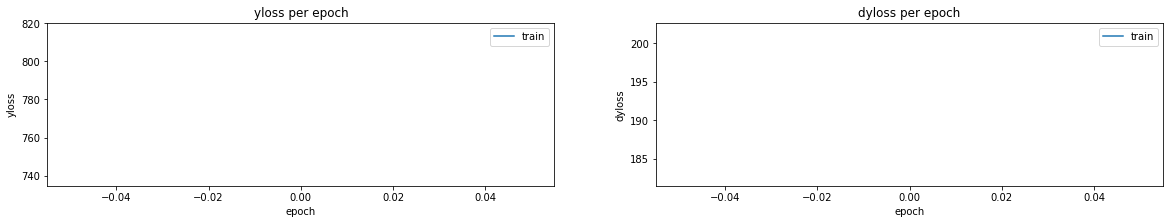

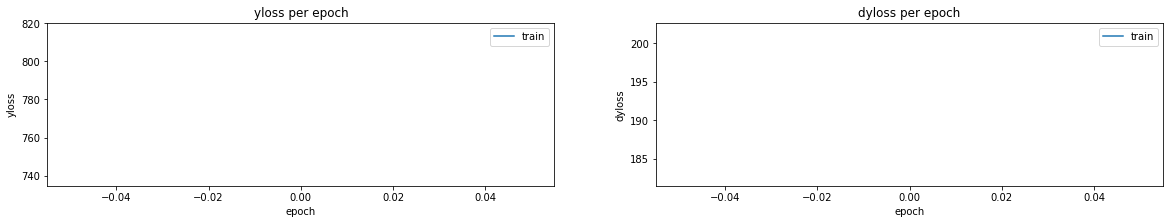

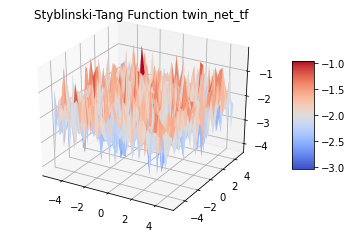

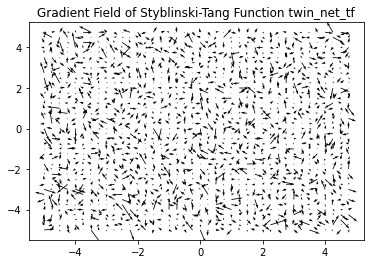

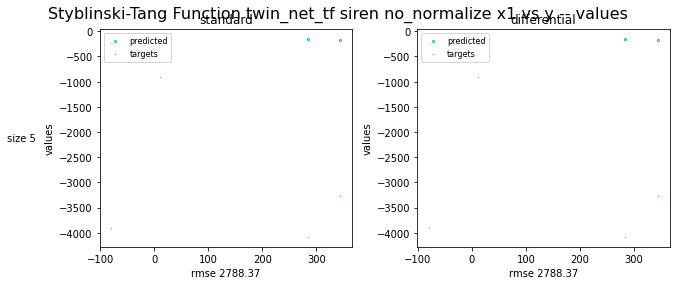

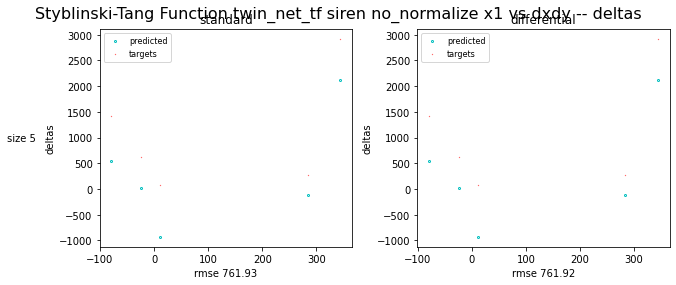

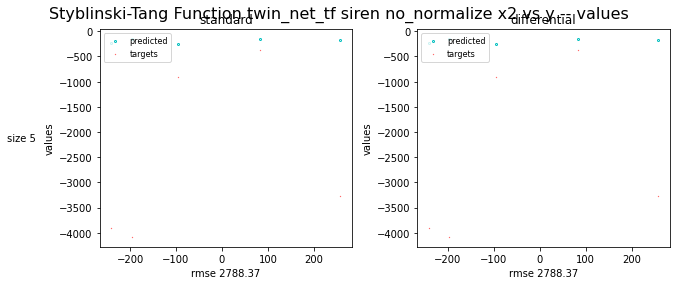

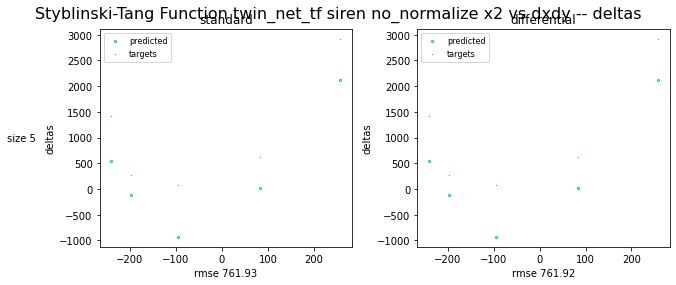

In [47]:
key3 = "no_normalize"
stats_dic[key1_1][key2][key3] = [None, None]
stats_dic[key1_2][key2][key3] = [None, None]
tests_loss[key1_1][key2][key3] = [None, None]
tests_loss[key1_2][key2][key3] = [None, None]

graph_name = "%s %s %s" % (name_function, key2, key3)
regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad, 
                                   siren = True, normalize = False)

stats_dic[key1_1][key2][key3][0] = stats_dic[key1_1][key2][key3][1] = regressor.stats["normal"]
stats_dic[key1_2][key2][key3][0] = stats_dic[key1_2][key2][key3][1] = regressor.stats["differential"]
tests_loss[key1_1][key2][key3][0] = tests_loss[key1_1][key2][key3][1] = loss["normal"]
tests_loss[key1_2][key2][key3][0] = tests_loss[key1_2][key2][key3][1] = loss["differential"]

### **3.2.2) normalize = True**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 5


Epoch 0: y loss scaled : 4.573474884033203, dy loss _scaled : 85.95440673828125

y loss no scaled : 1107.0540771484375, dy loss no scaled : 1.159995198249817



test y loss : 1107.0540771484375, test dy loss : 6401.0751953125


Epoch 0: y loss scaled : 4.573566913604736, dy loss _scaled : 85.9469223022461

y loss no scaled : 1107.076416015625, dy loss no scaled : 1.159893274307251



test y loss : 1107.076416015625, test dy loss : 6400.52197265625


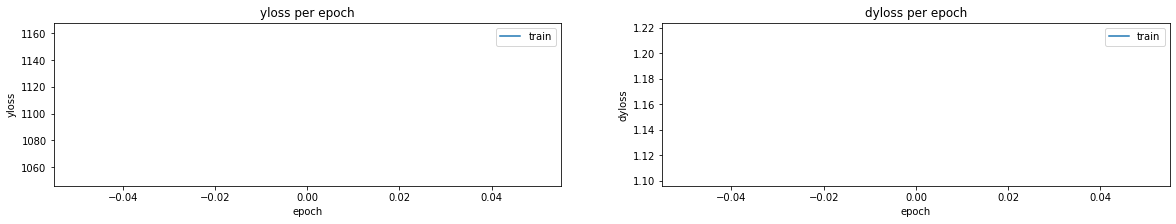

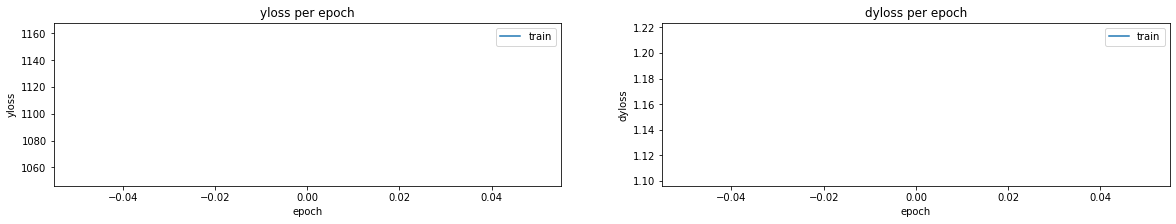

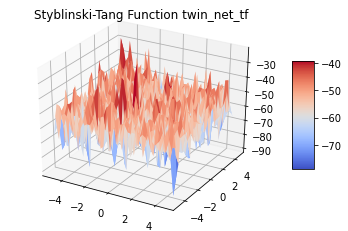

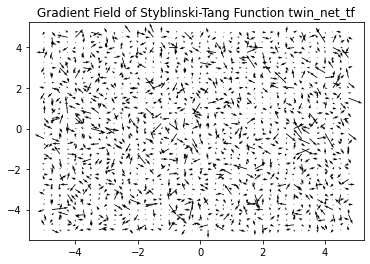

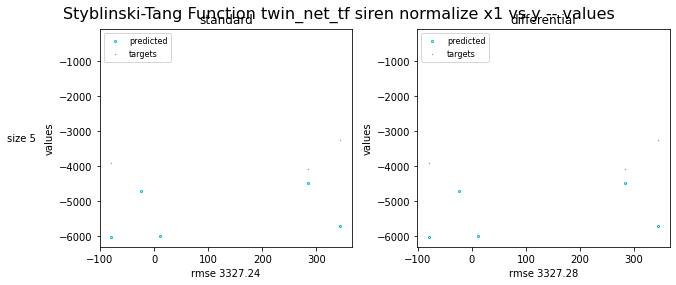

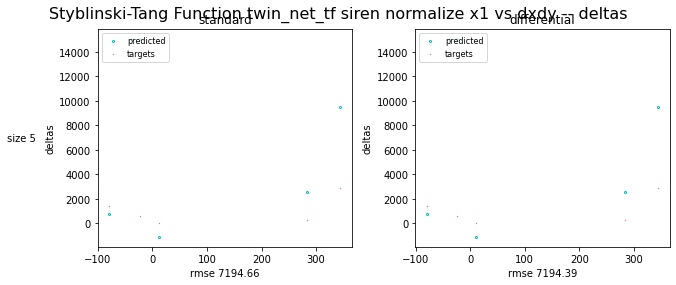

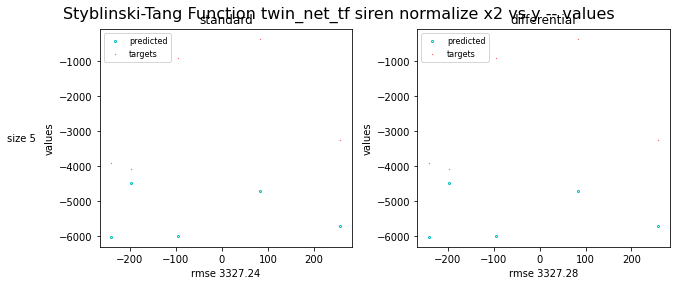

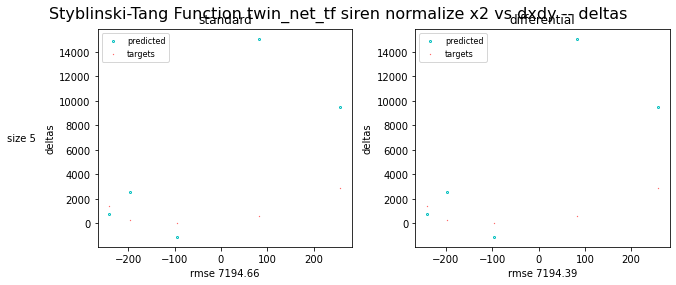

In [48]:
key3 = "normalize"
stats_dic[key1_1][key2][key3] = [None, None]
stats_dic[key1_2][key2][key3] = [None, None]
tests_loss[key1_1][key2][key3] = [None, None]
tests_loss[key1_2][key2][key3] = [None, None]

graph_name = "%s %s %s" % (name_function, key2, key3)
regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad, 
                                   siren = True, normalize = True)

stats_dic[key1_1][key2][key3][0] = stats_dic[key1_1][key2][key3][1] = regressor.stats["normal"]
stats_dic[key1_2][key2][key3][0] = stats_dic[key1_2][key2][key3][1] = regressor.stats["differential"]
tests_loss[key1_1][key2][key3][0] = tests_loss[key1_1][key2][key3][1] = loss["normal"]
tests_loss[key1_2][key2][key3][0] = tests_loss[key1_2][key2][key3][1] = loss["differential"]

# **4) twin_net pytorch**

In [49]:
name = "twin_net"
with_derivative = True
key1 = "twin_net_pytorch"
name_function = '%s %s' % (function, key1)
name_grad = '%s %s' % (grad, key1)
stats_dic[key1] = {}
tests_loss[key1] = {}

## **4.1) with MLP**

In [50]:
model_class = MLP
key2 = "mlp"
stats_dic[key1][key2] = {}
tests_loss[key1][key2] = {}

### **4.1.1) normalize = False**

In [51]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 1386.6318359375, y loss : 131.4425048828125, dy loss : 1255.1893310546875

train loss no scaled: 1386.6318359375, y loss  no scaled : 131.4425048828125, dy loss  no scaled: 1255.1893310546875






test loss: 5996.7724609375, y loss : 2597.990234375, dydx loss : 3398.782470703125

test loss no scaled: 5996.772705078125, y loss  no scaled : 2597.990234375, dydx loss  no scaled: 3398.782470703125




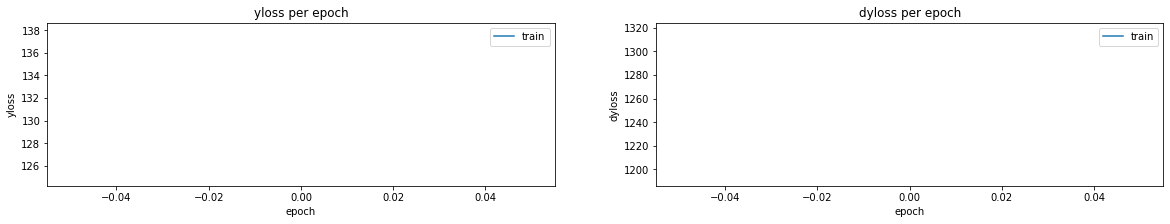

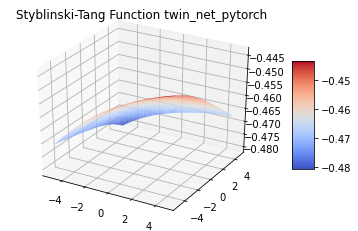

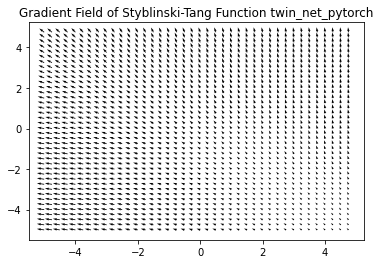

In [52]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(
          name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = True, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 1404.254638671875, y loss : 149.06448364257812, dy loss : 1255.190185546875

train loss no scaled: 1404.2546691894531, y loss  no scaled : 149.06448364257812, dy loss  no scaled: 1255.190185546875






test loss: 5999.1044921875, y loss : 2600.25634765625, dydx loss : 3398.848388671875

test loss no scaled: 5999.104736328125, y loss  no scaled : 2600.25634765625, dydx loss  no scaled: 3398.848388671875




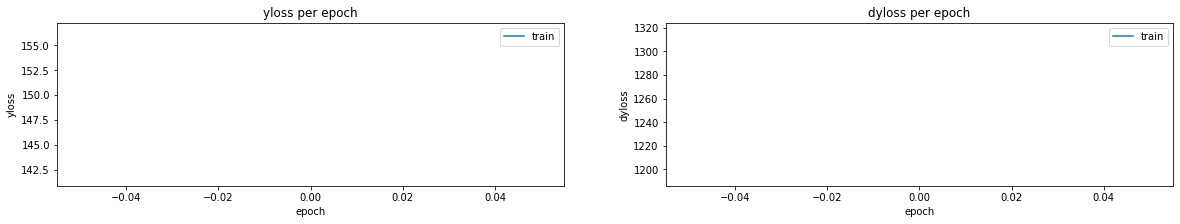

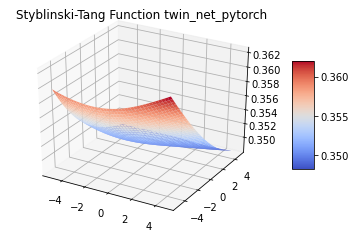

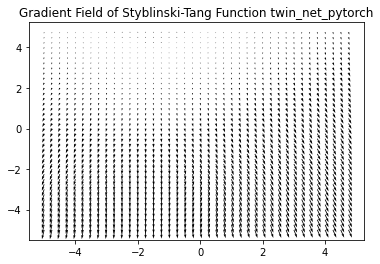

In [53]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(
          name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = True, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = learning_rate_schedule
        )

### **4.1.2) normalize = True**

In [54]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 2.3422369956970215, y loss : 1.3420696258544922, dy loss : 1.0001673698425293

train loss no scaled: 1242.1039065267607, y loss  no scaled : 30.223276138305664, dy loss  no scaled: 1211.880630388455






test loss: 156.4476617639565, y loss : 117.25064849853516, dydx loss : 39.19701326542135

test loss no scaled: 6355.072058952177, y loss  no scaled : 2640.4736328125, dydx loss  no scaled: 3714.598426139677




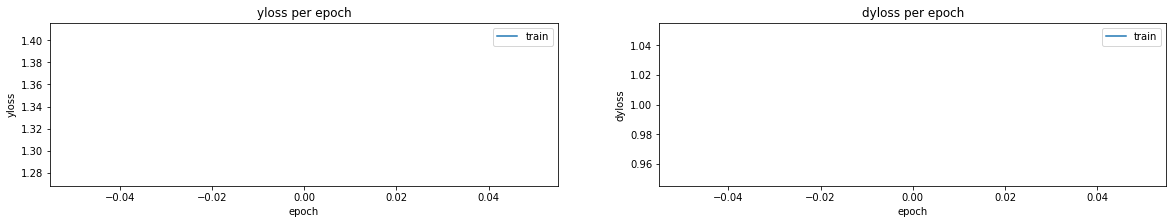

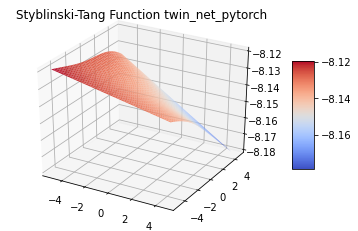

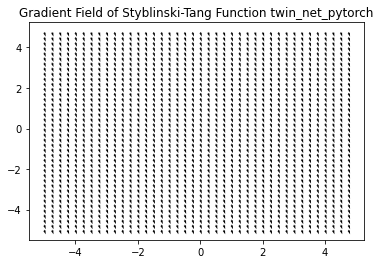

In [55]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(
          name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 2.0195183753967285, y loss : 1.0195232629776, dy loss : 0.9999951124191284

train loss no scaled: 1234.4651106502486, y loss  no scaled : 22.95956802368164, dy loss  no scaled: 1211.505542626567






test loss: 158.9003578886868, y loss : 119.70576477050781, dydx loss : 39.194593118179014

test loss no scaled: 6411.3163832555865, y loss  no scaled : 2695.762939453125, dydx loss  no scaled: 3715.5534438024615




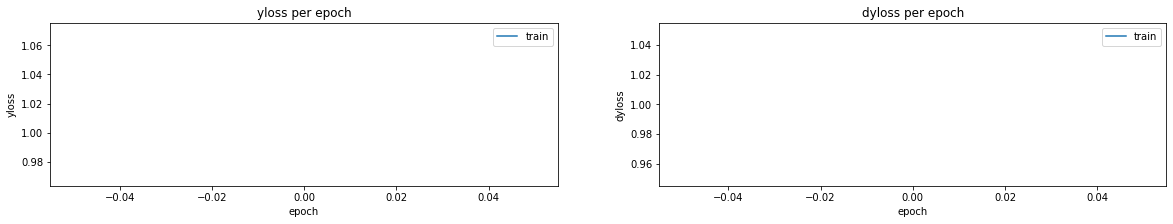

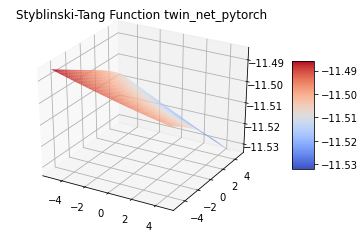

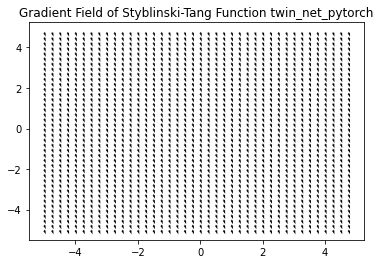

In [56]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = mlp_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = learning_rate_schedule
        )

## **4.2) with Siren**

In [57]:
model_class = Siren
key2 = "siren"
stats_dic[key1][key2] = {}
tests_loss[key1][key2] = {}

### **4.2.1) normalize = False**

In [58]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 1400.3070068359375, y loss : 141.2650909423828, dy loss : 1259.0418701171875

train loss no scaled: 1400.3069610595703, y loss  no scaled : 141.2650909423828, dy loss  no scaled: 1259.0418701171875






test loss: 5995.37890625, y loss : 2598.3837890625, dydx loss : 3396.995361328125

test loss no scaled: 5995.379150390625, y loss  no scaled : 2598.3837890625, dydx loss  no scaled: 3396.995361328125




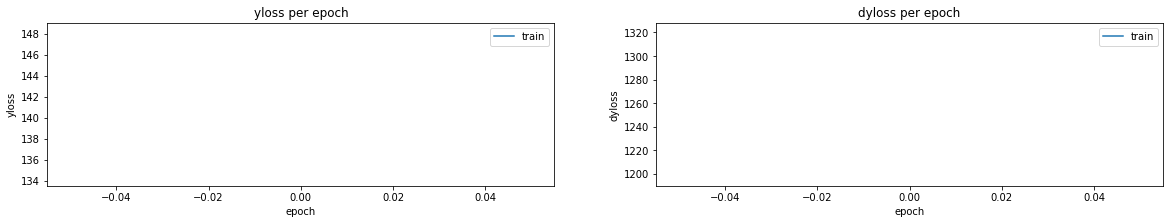

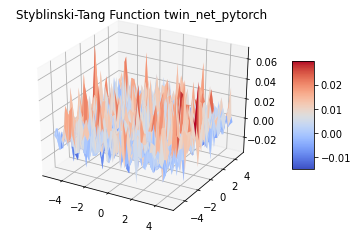

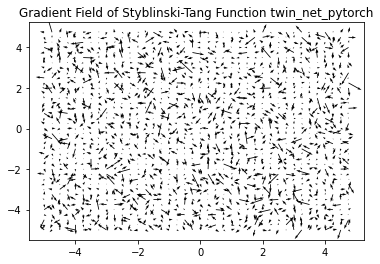

In [59]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = True, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 1402.440673828125, y loss : 142.76461791992188, dy loss : 1259.676025390625

train loss no scaled: 1402.4406433105469, y loss  no scaled : 142.76461791992188, dy loss  no scaled: 1259.676025390625






test loss: 5981.876953125, y loss : 2600.18310546875, dydx loss : 3381.69384765625

test loss no scaled: 5981.876953125, y loss  no scaled : 2600.18310546875, dydx loss  no scaled: 3381.69384765625




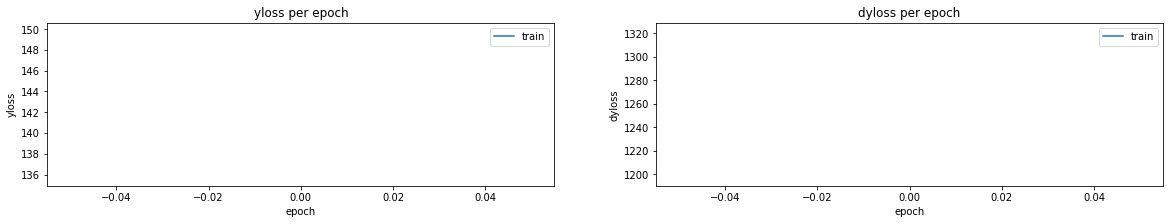

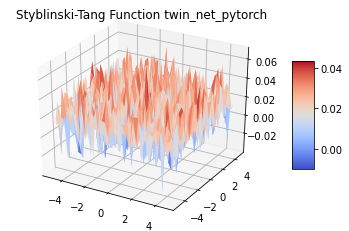

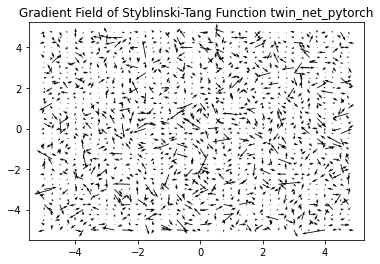

In [60]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = True, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = False,
          learning_rate_schedule = learning_rate_schedule
        )

### **4.2.2) normalize = True**

In [61]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]
tests_loss[key1][key2][key3] = [None, None]

Epoch 0: train loss: 2.0236284732818604, y loss : 1.045002818107605, dy loss : 0.9786256551742554

train loss no scaled: 1003.1317233799812, y loss  no scaled : 23.53336524963379, dy loss  no scaled: 979.5983581303474






test loss: 158.06486318728602, y loss : 118.91217041015625, dydx loss : 39.152692777129765

test loss no scaled: 7260.783821346908, y loss  no scaled : 2677.891357421875, dydx loss  no scaled: 4582.892463925033




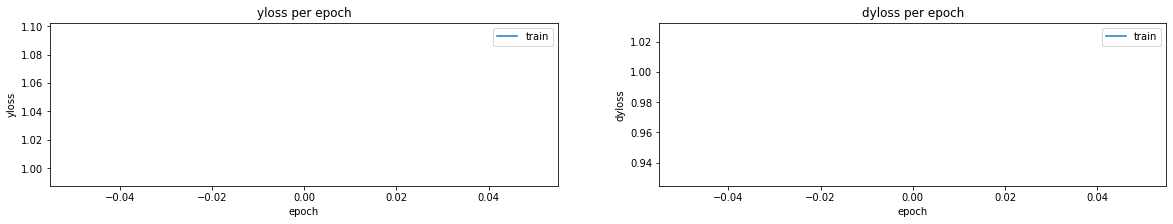

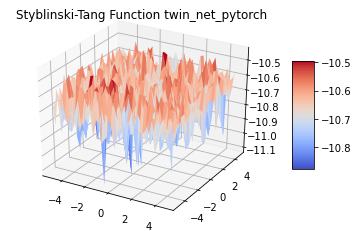

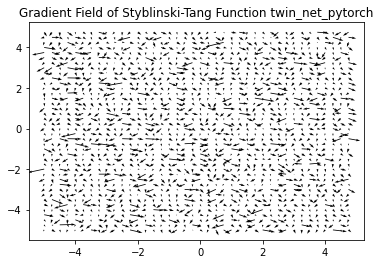

In [62]:
model, tests_loss[key1][key2][key3][0], stats_dic[key1][key2][key3][0] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = None
        )

Epoch 0: train loss: 1.9641408920288086, y loss : 1.0078166723251343, dy loss : 0.9563242793083191

train loss no scaled: 1148.8258884330219, y loss  no scaled : 22.695934295654297, dy loss  no scaled: 1126.1299541373676






test loss: 158.09355047797925, y loss : 118.32463073730469, dydx loss : 39.76891974067455

test loss no scaled: 6492.4233825711435, y loss  no scaled : 2664.65966796875, dydx loss  no scaled: 3827.763714602394




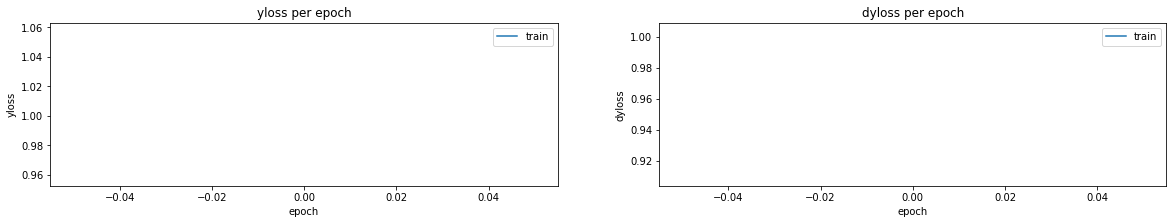

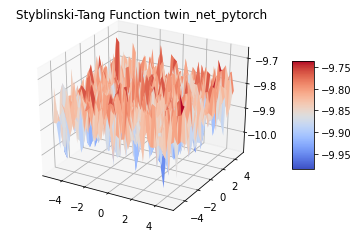

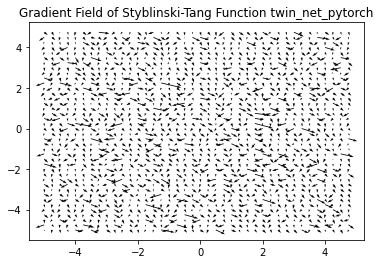

In [63]:
model, tests_loss[key1][key2][key3][1], stats_dic[key1][key2][key3][1] = run_train(name = name, 
          model_class = model_class, 
          model_kwargs = siren_model_kwargs, 
          with_derivative = with_derivative, 
          name_function = name_function, 
          name_grad = name_grad,  
          normalize = True,
          learning_rate_schedule = learning_rate_schedule
        )

# **5) Global Stats**

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


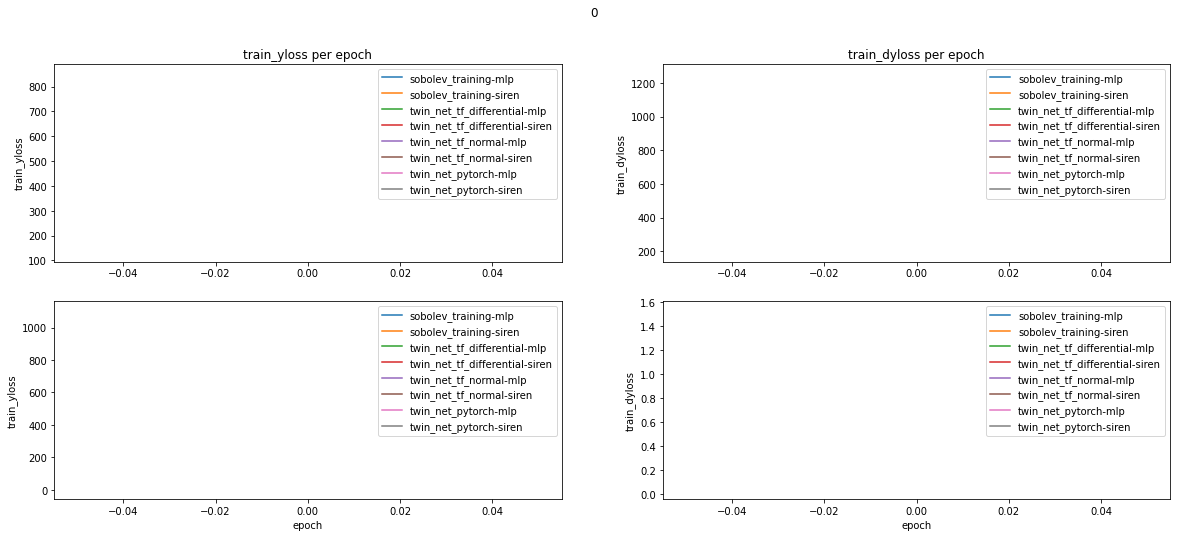

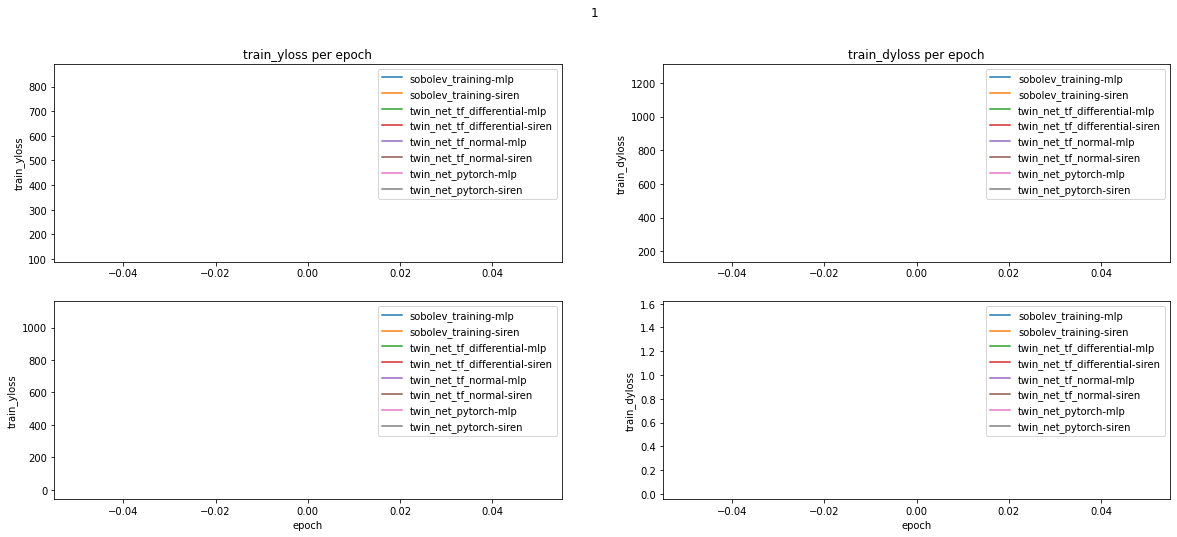

In [64]:
global_stat(stats_dic, suptitle = function)

In [65]:
rows, result = to_csv(dico = tests_loss, csv_path = csv_path, n_samples = str(nTrain), mode='a+')